In [1]:
import pandas as pd
import numpy as np
import pingouin as pg

from bootstrap import get_bootstrap
from split_system import aa_ttest

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
    
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

import warnings
warnings.filterwarnings('ignore')

sns.set(
    style="whitegrid",
    rc={'figure.figsize':(12,8)}
        )

### Постановка задачи

Представьте, что вы работаете в крупном дейтинговом приложении. Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен AА/Б тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:
- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

* *Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*

### Описание данных

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2).
Для каждой из них:

**users_*.csv** – информация о пользователях:
- uid – идентификатор пользователя
- age – возраст
- attraction_coeff –  коэффициент привлекательности (от 0 до 1000, $\frac{лайки}{просмотры}*1000$ ) 
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка
 
**transactions_*.csv** – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

#### **Порядок работы:**
1. Загружаем данные
2. Покрутим данные - проверка на дубликаты, пропуски, пересечения в группах
3. Предобработка данных для анализа
4. Проверка качества системы сплитования
5. Оценка контролируемого эксперимента
6. Выводы

### Загружаем данные

In [2]:
# Функция для считывания данных с Яндекс.Диска
def get_data(df_url, sep=';', dates_columns=None):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=df_url))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    df = pd.read_csv(download_url, sep=sep, parse_dates=dates_columns)
    
    return df

In [3]:
# Ссылки на данные

url_users_test = 'https://disk.yandex.ru/d/L8HxRYDn2l4h9A'
url_users_control_1 = 'https://disk.yandex.ru/d/TxOD_JxnkMd4mA'
url_users_control_2 = 'https://disk.yandex.ru/d/YT6OWRK2cTWfLg'
url_transactions_test = 'https://disk.yandex.ru/d/3viYBnm7cyihkQ'
url_transactions_control_1 = 'https://disk.yandex.ru/d/84jzzJeQ4tqVyg'
url_transactions_control_2 = 'https://disk.yandex.ru/d/_pOo7mrDCZZMyA'

In [4]:
# Считаем данные

users_test = get_data(url_users_test)
users_control_1 = get_data(url_users_control_1)
users_control_2 = get_data(url_users_control_2)
transactions_test = get_data(url_transactions_test, dates_columns=['paid_at', 'joined_at'])
transactions_control_1 = get_data(url_transactions_control_1, dates_columns=['paid_at', 'joined_at'])
transactions_control_2 = get_data(url_transactions_control_2, dates_columns=['paid_at', 'joined_at'])

### Предобработаем данные

In [5]:
# Напишем функцию для проверки данных

def df_info(df):
    '''Принимает датафрейм и возвращает количество строк и колонок в нем, типы данных, 
       название колонок с пропущенными значениями и их количество, а также колонки с дубликатами'''
    
    # Размер датафрейма
    nrows = df.shape[0]
    ncolumns = df.shape[1]
    
    nrows_wo_dup = df.drop_duplicates().shape[0]
    # Типы данных
    d_types = df.dtypes
    # Пропуски
    df_nan = df.isna().sum()
    
    # Определяем колонки с дубликатами
    columns_with_duplicates = []
    cols = df.columns
    for i in range(ncolumns):
        if df.iloc[:, i].nunique() != nrows:
            columns_with_duplicates.append(cols[i])
        continue
    
    print(f'Количество строк: {nrows}', f'Количество столбцов: {ncolumns}',
          f'Количество строк - полных дубликатов: {nrows - nrows_wo_dup}', sep='\n', end='\n\n')
    print(f'Типы данных:', d_types, sep='\n', end='\n\n')
    print(f'Пропущенные значения:', df_nan, sep='\n', end='\n\n')            
    print(f'Колонки, в которых есть дубликаты: {columns_with_duplicates}')
    
    return df.sample(5)

Для разведывательного анализа объединим все группы вместе

Тоже самое сделаем для таблиц с оплатами

In [6]:
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
users_full = pd.concat([users_test, users_control_1, users_control_2])

In [7]:
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'
transactions_full = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [8]:
df_info(users_full)

Количество строк: 12912
Количество столбцов: 14
Количество строк - полных дубликатов: 0

Типы данных:
uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
group                object
dtype: object

Пропущенные значения:
uid                     0
age                     0
attraction_coeff        0
coins               12742
country                 0
visit_days           4018
gender                  0
age_filter_start        0
age_filter_end          0
views_count             0
was_premium         11657
is_premium          12372
total_revenue           0
group                   0
dtype: int64

Колонки, в которых есть дубликаты: ['age', 'attraction_coeff', 'coins', 'country', 'visit_d

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
3938,891066768,29,1000,NaN,Chile,"2,3,4",1,26,32,3,NaN,NaN,0,control_1
479,891575181,37,90,NaN,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13",1,18,40,33,NaN,NaN,0,control_1
3496,892080222,33,500,NaN,Canada,NaN,1,20,71,2,NaN,NaN,0,control_2
3225,892141254,27,1000,NaN,United States of America,NaN,1,24,30,2,NaN,NaN,0,control_2
3920,892418583,21,666,NaN,United States of America,NaN,1,18,24,3,NaN,NaN,0,test


In [9]:
users_full.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,1.291200e+04,12912.000000,12912.000000,170.000000,12912.000000,12912.000000,12912.000000,12912.000000,1255.0,540.0,12912.000000
mean,8.917569e+08,32.010378,315.455545,688.958824,0.955158,26.815985,38.568463,46.641032,1.0,1.0,526.837283
std,1.610285e+06,10.224415,323.488766,7690.943033,0.206965,9.447197,15.511204,285.324194,0.0,0.0,5524.662716
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913565e+08,25.000000,0.000000,6.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917255e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920860e+08,38.000000,529.000000,28.000000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000
max,1.053059e+09,99.000000,1000.000000,99958.000000,1.000000,96.000000,102.000000,16157.000000,1.0,1.0,486330.000000


Что бросается в глаза? Есть пользователи, указавщие возраст 99 лет, скорее всего максимально возможный. Можно это исправить, например взяв средний возраст от границ фильтра поиска.

Также бросается в глаза явный гендорный дисбаланс) Трудновато будет найти себе подружку)

In [10]:
df_info(transactions_full)

Количество строк: 1608
Количество столбцов: 9
Количество строк - полных дубликатов: 662

Типы данных:
uid                    float64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
group                   object
dtype: object

Пропущенные значения:
uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
group             0
dtype: int64

Колонки, в которых есть дубликаты: ['uid', 'country', 'joined_at', 'paid_at', 'revenue', 'payment_id', 'from_page', 'product_type', 'group']


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
360,892069554.0,United Kingdom (Great Britain),2017-10-21 19:11:00,2017-03-11 10:44:00,3783.0,67.0,empty_likes,other_type,control_1
250,891722802.0,United States of America,2017-10-29 02:08:00,2017-04-11 17:46:00,1261.0,19.0,menu,coins,control_2
416,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
867,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
496,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1


In [11]:
transactions_full.describe()

,uid,revenue,payment_id
count,9.780000e+02,978.000000,978.000000
mean,8.920309e+08,7032.361963,94.592025
std,3.843685e+06,8655.787235,57.930448
min,8.910681e+08,26.000000,0.000000
25%,8.914837e+08,2577.250000,19.000000
50%,8.918626e+08,5804.500000,146.000000
75%,8.921428e+08,9087.000000,147.000000
max,9.609370e+08,113477.000000,147.000000


По транзакциям бросаются в глаза пользователи, потратившие значительно больше денег, чем в среднем трятят пользователи. Возможно, от выбросов придется избавиться.

Также имеются 630 записей с пропущенными строками, а также имеются 32 строчки - полные дубликаты. Посмотрим поподробнее

In [12]:
# Видим, что все эти записи в первой контрольной группе. Избавимся от них

transactions_full[transactions_full.uid.isna()].group.value_counts()

control_1    630
Name: group, dtype: int64

In [13]:
transactions_full.dropna(inplace=True, subset='uid')
transactions_control_1.dropna(inplace=True)

In [14]:
# Посмотрим на наши строки-дубликаты. Действительно, в транзакциях есть строчки-дубликаты. Могут исказить нам данные. Избавимся от них

transactions_full[transactions_full.duplicated(keep=False)].sort_values('uid')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
344,891252072.0,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261.0,19.0,empty_likes,coins,control_1
341,891252072.0,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261.0,19.0,empty_likes,coins,control_1
301,891320916.0,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783.0,67.0,empty_likes,other_type,control_1
227,891320916.0,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783.0,67.0,empty_likes,other_type,control_1
22,891365490.0,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19.0,empty_likes,coins,control_1
...,...,...,...,...,...,...,...,...,...
149,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,1261.0,19.0,gifts,coins,control_1
304,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,control_1
297,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,control_1
243,892339626.0,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754.0,19.0,empty_likes,coins,test


In [15]:
# Избавляемся от дубликатов

transactions_test.drop_duplicates(inplace=True)
transactions_control_1.drop_duplicates(inplace=True)
transactions_control_2.drop_duplicates(inplace=True)

In [16]:
# Посмотрим на размер групп. Тут все в порядке, размер групп различается в допустимых пределах

users_full.group.value_counts()

control_1    4340
test         4308
control_2    4264
Name: group, dtype: int64

Раз решил что-то делать с 99-летними дедами, давайте вернем их в молодость. Объявим функцию для корректировки возраста

На гистограмме распределения видно, что они застряли в районе 90-100 лет. Возьмем 80 как границу отсечения

<AxesSubplot:>

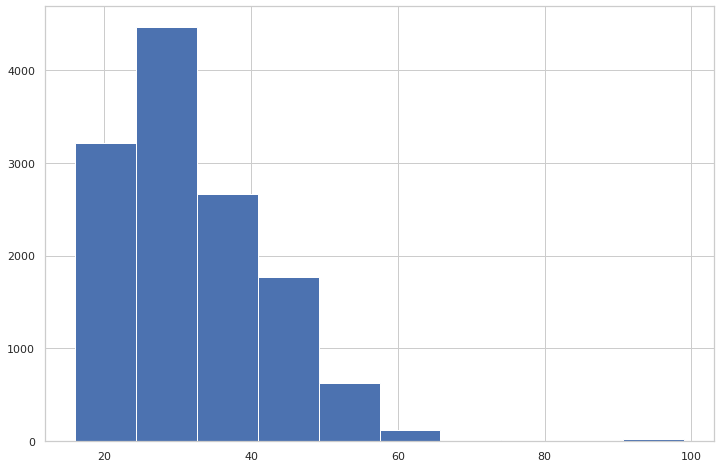

In [17]:
users_full.age.hist()

In [18]:
def change_users_df(df):
    '''Принимает дафрейм, заменяет возраст пользователя, который указал неестественно большой возраст,
       на среднее между мин. значением и макс. значением фильтра поиска данного пользователя
       Также заменяет NaN в колонках coins, was_premium, is_premium на 0'''
    # Работаем с возрастом    
    temp_old = df.query('age > 80')
    temp_df = df.query('age <= 80')
    
    temp_old.age = temp_old[['age_filter_start', 'age_filter_end']].mean(axis=1)
    df_new = pd.concat([temp_old, temp_df])
    
    # Меняем nan на 0
    df_new.fillna({'was_premium': 0, 'is_premium': 0, 'coins': 0}, inplace=True)
    return df_new

In [19]:
# Применим функцию на датафреймы с группами

users_control_1 = change_users_df(users_control_1)
users_control_2 = change_users_df(users_control_2)
users_test = change_users_df(users_test)
users_full = change_users_df(users_full)

Посмотрим на даты проведения эксперимента. Видим, что, судя по совокупным данным даты проведения эксперимента 2017-01-11 - 2017-12-11.

In [20]:
# Узнаем в какой период проводилось тестирование

print( ' Дата первой транзакции в тестовой группе:', transactions_test['paid_at'].min(),'\n', \
       'Дата последней транзакции в тестовой группе:', transactions_test['paid_at'].max())

print( '\n Дата первой транзакции в контр. группе 1:', transactions_control_1['paid_at'].min(),'\n', \
       'Дата последней транзакции в контр. группе 1:', transactions_control_1['paid_at'].max())

print( '\n Дата первой транзакции в контр. группе 2:', transactions_control_2['paid_at'].min(),'\n', \
       'Дата последней транзакции в контр. группе 2:', transactions_control_2['paid_at'].max())

 Дата первой транзакции в тестовой группе: 2017-01-11 04:37:00 
 Дата последней транзакции в тестовой группе: 2017-12-11 22:06:00

 Дата первой транзакции в контр. группе 1: 2016-12-14 16:16:00 
 Дата последней транзакции в контр. группе 1: 2017-12-11 21:57:00

 Дата первой транзакции в контр. группе 2: 2017-01-11 05:34:00 
 Дата последней транзакции в контр. группе 2: 2017-12-11 23:28:00


Но у нас тут затесались лозутчики, с транзакциями в декабре 2016го года. Посмотрим на них. Наш соотечественник заблудился, избавимся от него

In [21]:
transactions_control_1.query('paid_at < "2017-01-11"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1


In [22]:
transactions_control_1 = transactions_control_1.query('uid != 960936960')

Также были обнаружены пользователи с датой покупки, меньшей, чем дата регистрации. Сложный вопрос что это и почему произошло. Возможные варианты: 
* Ошибка в логировании
* Ошибка в выгрузке данных
* Ошибка в логике присвоения айдишников или очистки данных после удаления пользователя с сервиса с последующим переприсваиванием id

Правильного ответа я думаю тут нет, нет возможности установить причину. Оставлю их на месте


In [23]:
transactions_full.query('joined_at >= paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
11,891861048.0,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588.0,68.0,none,premium_no_trial,test
20,891806280.0,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242.0,147.0,trial_vip_popup,trial_premium,test
24,891786216.0,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818.0,147.0,trial_vip_popup,trial_premium,test
25,892057347.0,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209.0,19.0,none,coins,test
36,891589239.0,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305.0,19.0,empty_likes,coins,test
...,...,...,...,...,...,...,...,...,...
305,891606141.0,United States of America,2017-10-31 04:43:00,2017-03-11 21:13:00,3783.0,67.0,empty_likes,other_type,control_2
313,891691062.0,Belgium,2017-10-29 16:19:00,2017-05-11 18:35:00,16614.0,147.0,popular_users_block,trial_premium,control_2
314,892075512.0,United States of America,2017-10-21 16:58:00,2017-08-11 12:18:00,9958.0,147.0,trial_vip_popup,trial_premium,control_2
315,891722802.0,United States of America,2017-10-29 02:08:00,2017-05-11 05:49:00,12727.0,147.0,trial_vip_popup,trial_premium,control_2


### Покрутим данные

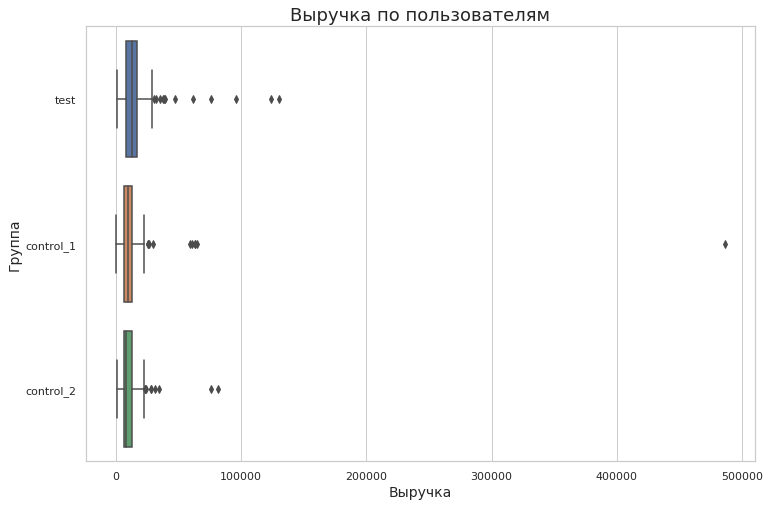

In [24]:
 # Построим боксплоты по выручке
ax = sns.boxplot(data=users_full.query('total_revenue > 0'), x='total_revenue', y='group')
ax.axes.set_title("Выручка по пользователям", fontsize=18)
ax.set_xlabel("Выручка", fontsize=14)
ax.set_ylabel("Группа", fontsize=14)
plt.show()

В первую контрольную группу попал какой-то жесткий Казанова, посмотрим что за человечек такой

In [25]:
users_full.reset_index(inplace=True)

kazanova_id = users_full.loc[users_full.total_revenue.idxmax()].uid
print(kazanova_id)

892333905


In [26]:
# Посмотрим на его транзакции

transactions_control_1.query('uid == @kazanova_id')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
6,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins,control_1
13,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,control_1
28,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,control_1
43,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,control_1
49,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,control_1
63,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 22:35:00,31525.0,19.0,menu,coins,control_1
76,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 18:42:00,31525.0,19.0,fans,coins,control_1
126,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 22:39:00,19773.0,146.0,menu,coins,control_1
137,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,31525.0,19.0,gifts,coins,control_1
143,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147.0,no_sympathy,premium_no_trial,control_1


Вроде ничего криминального, но он сгенерировал большУю часть выручки в первой контрольной группе, что может негативно сказаться на результатах стат. тестов. Избавимся от товарища

In [27]:
transactions_control_1 = transactions_control_1.query('uid != 892333905')
users_control_1 = users_control_1.query('uid != 892333905')

transactions_full = transactions_full.query('uid != 892333905')
users_full = users_full.query('uid != 892333905')

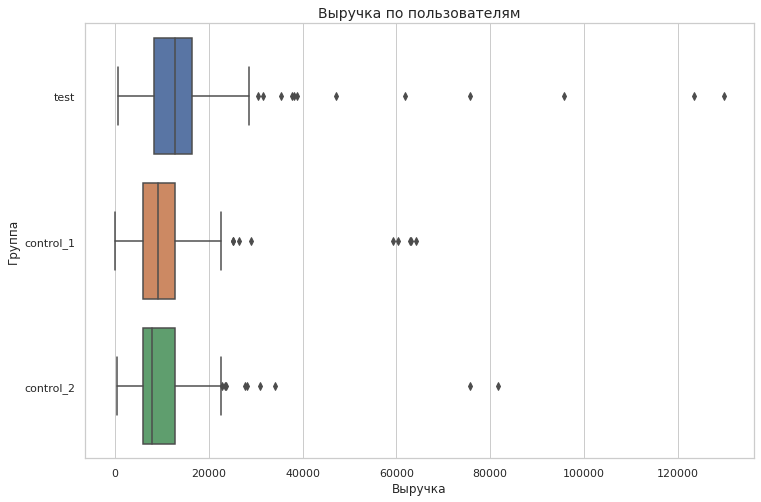

In [28]:
 # Построим на выручку после избавления от выброса
ax = sns.boxplot(data=users_full.query('total_revenue > 0'), x='total_revenue', y='group')
ax.axes.set_title("Выручка по пользователям", fontsize=14)
ax.set_xlabel("Выручка")
ax.set_ylabel("Группа")
plt.show()

Вопрос в том, счиатать ли остальных пользователей с высоким тратами выбросами в данных. Они не совсем типичны для среднестатистического пользователя приложения. 

Нормальностью распределения в данном случае и не пахнет, мы имеем типичное для трат скошенное вправо распределение. В качестве статистического оценщика предлагаю выбрать классический t-test. Объясню почему:
1. У нас в распределении revenue есть множество повторяющихся значений (пользователи с 0 тратами), что для непараметрического аналога - теста Манна-Уитни, негативно скажется на чувствительности
2. Для ненормального распредления при больших объемах выборок допустимо использовать t-test, но мы будем пользоваться его модификацией, тестом Уэлча. Для этого укажем параметр equal_var=False. Это поможет нам получить более корректные данные на выборках с неравной дисперсией
3. t-test гораздо удобнее интерпретировать, особенно когда речь идет о таких понятных для бизнеса терминах как ARPU или ARPPU

### Проверка качества системы сплитования

Для оценки качества системы сплитования воспользуемся t-тестом. Т.к. t-тест требует независимости наших наблюдений, то оценивать систему спитования будем на основе значений total_revenue

  0%|          | 0/10000 [00:00<?, ?it/s]

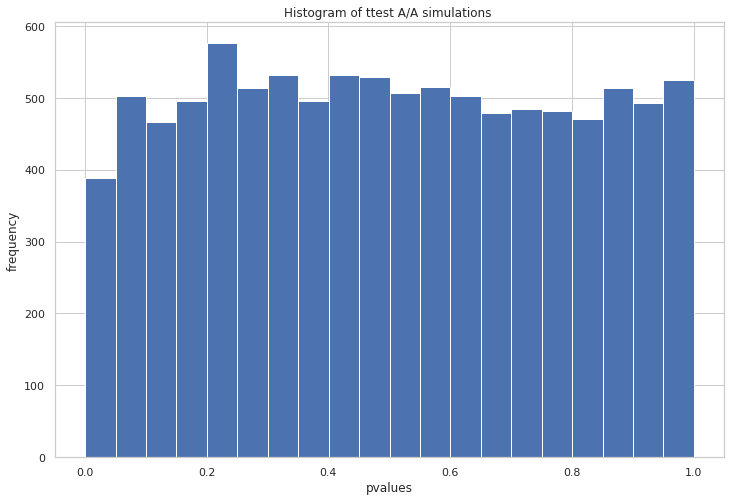

0.0382

In [29]:
aa_ttest(users_control_1.total_revenue, users_control_2.total_revenue, alpha=0.05, replace=False)

Распределие p-value похоже на равномерное, а FPR составляет < заданного уровня alpha. Это говорит нам о корректной работе системы сплитования

Дальше нам нужно понять, как мы работаем с двумя контрольными выборками. Будь моя воля, я бы задизайнил эксперимент по-другому (A/A тест проходит до проведения A/B и уже после проверки групп на идентичность мы присваиваем одной из них тестовый флаг)
Но эксперимент проводил не я) Поэтому наши варианты:
1. Отклонение при разногласии - мы принимаем альтернативную гипотезу, если она принимается при сравнении с каждым из контролей. В данном варианте мы получаем более низкий FPR, но возрастает вероятность получить ошибку II рода
2. Выбор «лучшего» контроля - попытка определить, какой из контролей является лучшей моделью генеральной совокупности. Тут попахивает проблемой подглядывания)
3. Выбор любого из двух контролей - тут мы натыкаемся на проблему множественного сравнения. FPR увеличивается и мы приходим к необходимости применения поправки Бофнеррони

Подробнее про проблематику A/A/B тестирования в [статье](https://koch-kir.medium.com/не-стоит-проводить-а-а-в-тест-936e9e7a3b96)

In [30]:
# Давайте подробнее посмотрим на характеристики групп

users_test.describe()[['age', 'gender', 'is_premium', 'total_revenue']][0:3]

,age,gender,is_premium,total_revenue
count,4308.000000,4308.000000,4308.000000,4308.000000
mean,31.772864,0.953110,0.036444,534.080316
std,9.839701,0.211427,0.187414,4371.682632


In [31]:
users_control_1.describe()[['age', 'gender', 'is_premium', 'total_revenue']][0:3]

,age,gender,is_premium,total_revenue
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,32.009564,0.958055,0.044019,482.815626
std,9.919023,0.200487,0.205162,3069.244522


In [32]:
users_control_2.describe()[['age', 'gender', 'is_premium', 'total_revenue']][0:3]

,age,gender,is_premium,total_revenue
count,4264.000000,4264.000000,4264.000000,4264.000000
mean,31.983935,0.954268,0.044794,450.384146
std,9.968066,0.208927,0.206875,2859.242228


Как видно, описательные статистики в контрольных группах не совсем сходятся. Характер распределения total revenue явно различается не только по среднему значению, но и по медиане (видно на боксплотах выше). Поэтому предлагаю прибегнуть к первому варианту работы с двумя тестовыми группами - будем принимать альтернативную гипотезу при ее статистически значимом результате как для первой, так и для второй групп

### Тестирование гипотез. 

#### Успешен ли эксперимент в общем

Для начала определимся с метриками. Помимо увеличения дохода, нас также интересует, значимо ли снизилась конверсия в премиум-пользователя (из анализа характеристик групп мы видим, что процент пользователей премиума снизился)
Поэтому предлагаю следующий набор метрик - ARPPU как метрика, отражающая выручку и внутригрупповая конверсия в покупку, для анализа стат. значимости падения количества платящих полоьзователей

In [44]:
# Посчитаем метрики для тестовой и контрольных групп
metrics = pd.DataFrame({'group_size': users_full.groupby('group').uid.nunique(),
                        'group_size_pay': users_full.query('total_revenue > 0').groupby('group').uid.nunique(),
                        'ARPPU': round(users_full.query('total_revenue > 0').groupby('group').total_revenue.mean(), 2),
                        'CR_tobuy': round(users_full.query('total_revenue > 0').groupby('group').uid.nunique() / \
                                    users_full.groupby('group').uid.nunique(), 3)
                        }).reset_index ()
metrics

,group,group_size,group_size_pay,ARPPU,CR_tobuy,CR_toprem
0,control_1,4339,191,10968.26,0.044,0.044
1,control_2,4264,187,10269.72,0.044,0.045
2,test,4308,146,15759.03,0.034,0.036


По рассчитанным метрикам для контрольных и тестовой группы видно, что ARPPU в тестовой группе ощутимо вырос, но CR в покупку снизился


Попарно сравним контрольные группы с тестовой, для установления стат.значимости увеличения ARPPU

**H0**: μB = μA

**H1**: μB ≠ μA

Для начала проверим наши группы на равенство дисперсий

In [99]:
pg.homoscedasticity(users_full.query('total_revenue > 0'), dv='total_revenue', group='group')

,W,pval,equal_var
levene,3.505458,0.030743,False


Равенство дисперсий нее соблюдается, поэтому воспользуемся критерием Геймса-Хоувелла

In [100]:
pg.pairwise_gameshowell(users_full.query('total_revenue > 0'), dv='total_revenue', between='group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,control_1,control_2,10968.256545,10269.721925,698.534619,990.251581,0.705411,375.004890,0.760441,0.072424
1,control_1,test,10968.256545,15759.027397,-4790.770853,1659.609047,-2.886686,211.715485,0.011914,-0.316627
2,control_2,test,10269.721925,15759.027397,-5489.305472,1641.145809,-3.344801,204.105443,0.002806,-0.368561


ARPPU статистически значимо увеличился и для первой и для второй контрольной групп. Хороший знак)

Теперь проверим статистически ли значимо снижение конверсии. Для этого воспользуемся тестом хи-квадрат

**H0**: Взаимосвязь между системой оплаты и конверсией отсутствует

**H1**: Взаимосвязь между системой оплаты и конверсией есть

In [39]:
# Добавим колонку со статусом оплаты
users_full['pay'] = users_full.total_revenue > 0

In [40]:
expected, observed, stats = pg.chi2_independence(users_full.query('group == "test" or group == "control_1"'), x='group', y='pay', correction=False)

In [41]:
print(stats.pval[0])
observed


0.014957835665042


pay,False,True
group,,
control_1,4148,191
test,4162,146


In [42]:
expected, observed, stats = pg.chi2_independence(users_full.query('group == "test" or group == "control_2"'), x='group', y='pay', correction=False)

In [43]:
print(stats.pval[0])
observed

0.016971937437490116


pay,False,True
group,,
control_2,4077,187
test,4162,146


На уровне значимости 0,05 мы отклоняем нулевую гипотезу, что говорит нам о том, что конверсия в покупку статистически значимо снизилась как для первой контрольной, так и для второй контрольной группы

Результаты эксперимента показали себя неоднозначно. При увеличенном ARPPU мы наблюдаем статистически значимое снижение конверсии в тестовой группе. Для определения целесообразности введения новой системы оплаты, предлагаю посмотреть на метрику ARPU (средний чек на пользователя)

In [47]:
metrics_2 = pd.DataFrame({'group_size': users_full.groupby('group').uid.nunique(),
                        'group_size_pay': users_full.query('total_revenue > 0').groupby('group').uid.nunique(),
                        'ARPU': round(users_full.groupby('group').total_revenue.mean(), 2),
                        'ARPPU': round(users_full.query('total_revenue > 0').groupby('group').total_revenue.mean(), 2),
                        'CR_tobuy': round(users_full.query('total_revenue > 0').groupby('group').uid.nunique() / \
                                    users_full.groupby('group').uid.nunique(), 3)
                        }).reset_index ()
metrics_2

,group,group_size,group_size_pay,ARPU,ARPPU,CR_tobuy,CR_toprem
0,control_1,4339,191,482.82,10968.26,0.044,0.044
1,control_2,4264,187,450.38,10269.72,0.044,0.045
2,test,4308,146,534.08,15759.03,0.034,0.036


Видим, что ARPU в тестовой группе также показал рост. Воспользуемся критерием Геймса-Хоувелла для установления стат. значимости этого изменения

**H0**: μB = μA

**H1**: μB ≠ μA

In [102]:
pg.pairwise_gameshowell(users_full, dv='total_revenue', between='group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,control_1,control_2,482.815626,450.384146,32.431479,63.940158,0.507216,8576.581004,0.867829,0.010936
1,control_1,test,482.815626,534.080316,-51.264690,81.285756,-0.630672,7718.688139,0.803241,-0.013563
2,control_2,test,450.384146,534.080316,-83.696169,79.709365,-1.050017,7431.811566,0.545303,-0.022681


Критерий Геймса-Хоувелла не выявил статистически значимых изменений ARPU для тестовой группы (p-value > 0.05), что ставит под сомнения результаты нашего эксперимента.

#### Промежуточный вывод
На этапе общегруппового анализа не рекомендую внедрять новую систему оплаты, потому что она показала неоднозначные результаты. Несмотря на значимое увеличение среднего чека на платящего пользователя (ARPPU) мы имеем значимое падение конверсии в покупку, что ведет к незначительным изменениям среднего чека, а значит раскатка на всех пользователей не даст нам прирост к выручке

#### Имеет ли смысл нововведение среди конкретных групп пользователей

##### Посмотрим на тип транзакция для различных групп пользователей

In [55]:
product_type = transactions_full.groupby(['group', 'product_type'], as_index=False) \
                                .agg({'revenue': 'sum', 'uid': 'count',}) \
                                .rename(columns={'uid': 'transactions'})

product_type['ARPPU'] = round((product_type['revenue'] / product_type['transactions']), 2)

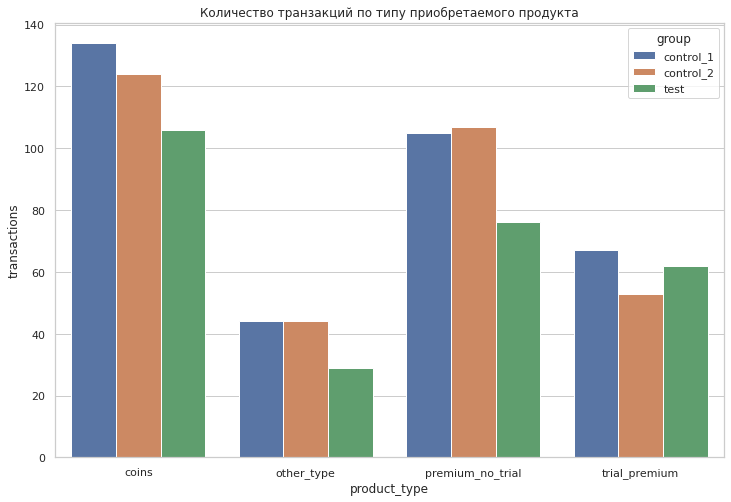

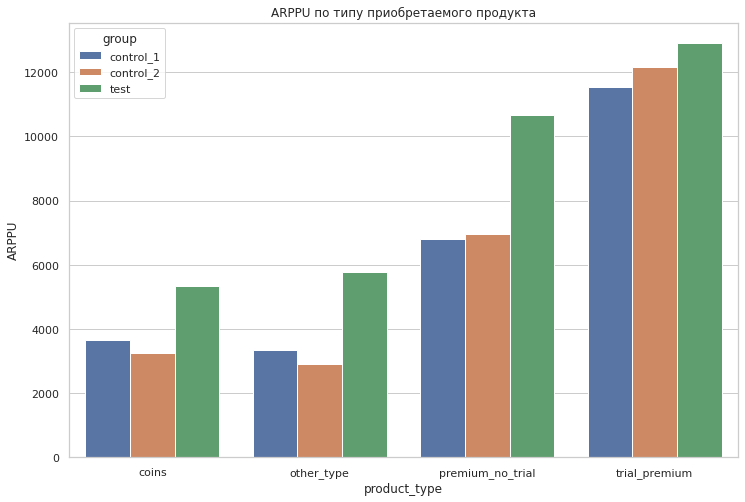

In [57]:
 # Строим барплоты:
plt.title("Количество транзакций по типу приобретаемого продукта")
sns.barplot(x="product_type", y="transactions", hue="group", data=product_type)
plt.show()

plt.title("ARPPU по типу приобретаемого продукта")
sns.barplot(x="product_type", y="ARPPU", hue="group", data=product_type)
plt.show()

Для различных транзакций наблюдаем схожую с общегрупповой тенденцию. Несмотря на выросший средний чек на платящего пользователя (ARPPU) мы наблюдаем снижение количества платежей

##### Посмотрим на изменения для различных возрастных категорий

In [68]:
# Для удобства анализа присвоим столбцу возраст категориальный формат
users_full['age_category'] = pd.cut(users_full['age'],
                                    bins=[15,23,35,46,100],
                                    labels=['<22','23-34','35-45','45+'])

Text(0, 0.5, 'Возрастная категория')

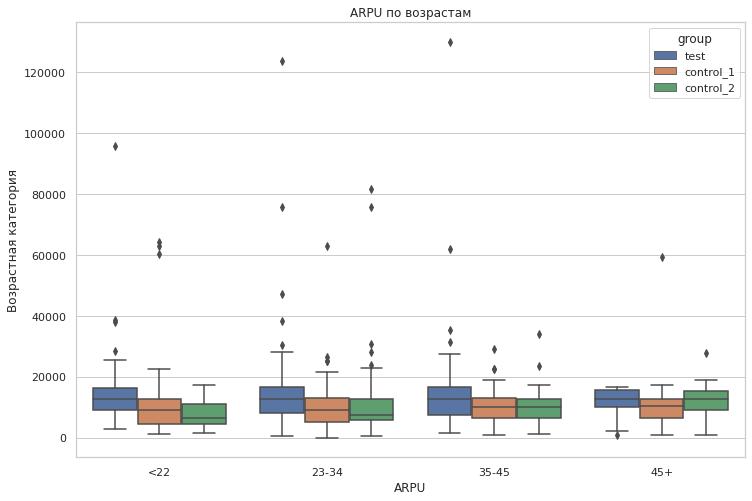

In [92]:
sns.boxplot(x = 'age_category', y='total_revenue', hue='group', data=users_full.query('total_revenue > 0'))
plt.title('ARPU по возрастам')
plt.xlabel('ARPU')
plt.ylabel('Возрастная категория')

Применим многофакторный дисперсионный анализ для оценки статистической значимости влияния возрастной категории на ARPU

In [103]:
pg.anova(data=users_full.query('pay == 1'), dv='total_revenue', between=['group', 'age_category'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,2.819358e+09,2.0,1.409679e+09,8.911410,0.000157,0.033639
1,age_category,3.458914e+07,3.0,1.152971e+07,0.072886,0.974495,0.000427
2,group * age_category,1.149452e+09,6.0,1.915753e+08,1.211060,0.298924,0.013994
3,Residual,8.099232e+10,512.0,1.581881e+08,NaN,NaN,NaN


Мы видим, что эффект фактора age_group незначим как сам по себе, так и через взаимодействие с группой

##### Посмотрим на изменения для стран

Для начала оставим для анализа страны, в которых больше 50 юзеров для избежания ошибок при применении стат. тестов

In [83]:
users_countries = users_full[users_full.country in (users_full.country.value_counts() > 50)[0]]

TypeError: argument of type 'numpy.bool_' is not iterable

In [81]:
users_full.groupby('country').uid.count()

country
Algeria                              4
Argentina                         1182
Armenia                              1
Australia                          163
Austria                              2
                                  ... 
United Kingdom (Great Britain)     461
United States of America          4407
Uruguay                              2
Uzbekistan                           1
Venezuela                            2
Name: uid, Length: 72, dtype: int64

In [87]:
(users_full.country.value_counts() > 50).sum()

15